# Overwatch Hero Survey (September 2019)
Links:
* Responses are based on this [Google Forms survey](https://forms.gle/Rgmn2CdViBApsbP6A) 
* The raw results can be found in this [Google Sheets spreadsheet](https://docs.google.com/spreadsheets/d/1Ax1unE4I2DWW3iz2Bv4c24FTUx_qxNPwrKGZ6LGNux0) 
* Original [reddit post](https://www.reddit.com/r/Competitiveoverwatch/comments/d9cmo9/5_minute_overwatch_hero_survey_fun_vs_perception/)
* The code used to generate the results can be found on [github](https://github.com/marksimpson82/overwatch_survey).

## Caveats
Firstly, the survey and analysis could contain bias or errors. 

I encourage folk to check out the [github repo](https://github.com/marksimpson82/overwatch_survey) and examine/fork & modify the code. 

## Goal
I'm curious about how the community perceives hero fun (playing as and against a specific hero) vs. balance. E.g.

### Are the usual suspects _really_ that OP/un-fun? 
Rationale: We see a lot of complaint threads focusing on whoever is meta, but does the community broadly hold the same opinions or is it just a loud vocal minority?

### For a player maining hero X, does hero Y grind their gears?
I'm also interested in who likes/dislikes certain heroes. E.g. my hunch is `Zen` mains hate `Doomfist` the most, while `Wrecking Ball` mains hate `Sombra` or possibly `Mei`.

## Future survey improvements (TODO):
* Collect platform (PC, PC, Xbox)
* Collect whether people enjoy playing _with_ a hero on their team

In [1]:
import pandas as pd
import seaborn as sb
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt

# load flat csv files -- the survey results are a little clunky
hero_names_df = pd.read_csv("../data/overwatch_heroes.csv").loc[:,["Hero_name"]]
basic_info_df = pd.read_csv("../data/table_basic_info.csv")
hero_ratings_df = pd.read_csv("../data/table_hero_ratings.csv")

# join on Response_id such that we can more easily query the result set
joined_df = basic_info_df.set_index('Response_id').join(
    hero_ratings_df.set_index('Response_id'), 
    lsuffix='caller', 
    rsuffix='_other')

In [2]:
# handy constants
COLUMN_PLAYING_AS="Playing_as"
COLUMN_PLAYING_VS="Playing_vs"

RATING_MIN=1
RATING_MAX=5

CHART_BAR_FIGSIZE=(6, 12)
CHART_HIST_FIGSIZE=(6, 6)

In [3]:
# helper functions for graphs
def set_graph_format_x_axis(ax):
    ax.set(xlim=(RATING_MIN, RATING_MAX))
    plt.xticks(np.arange(RATING_MIN, RATING_MAX + 1, 1))

In [4]:
def draw_fun_factor_graph(df, title):
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)                
    ax = sb.barplot(x="Value", y="Hero", data=df)
    set_graph_format_x_axis(ax)
    ax.set_title(title)
    ax.set(xlabel="Fun factor (higher is more enjoyable)")

## Q: Which heroes are fun play as?

In [5]:
def hero_fun_factor(df, response_type):
    return (df.query(f'Response_type == "{response_type}"')
            .groupby('Hero', as_index=False)
            .mean()
            .sort_values(by='Value'))

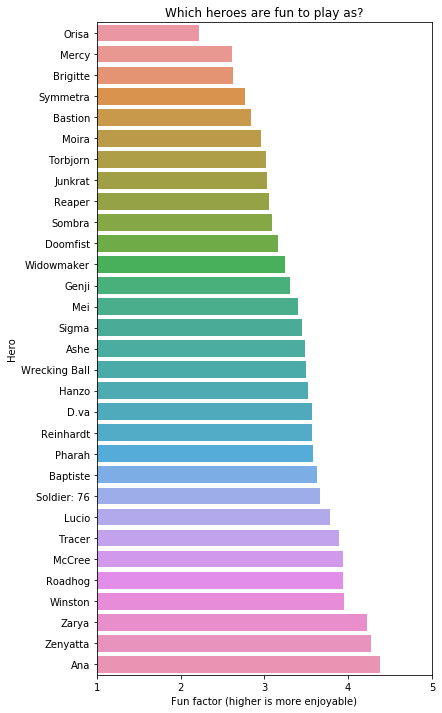

In [6]:
draw_fun_factor_graph(
    hero_fun_factor(joined_df, COLUMN_PLAYING_AS), 
    "Which heroes are fun to play as?")

## Q: Which heroes are fun play against?

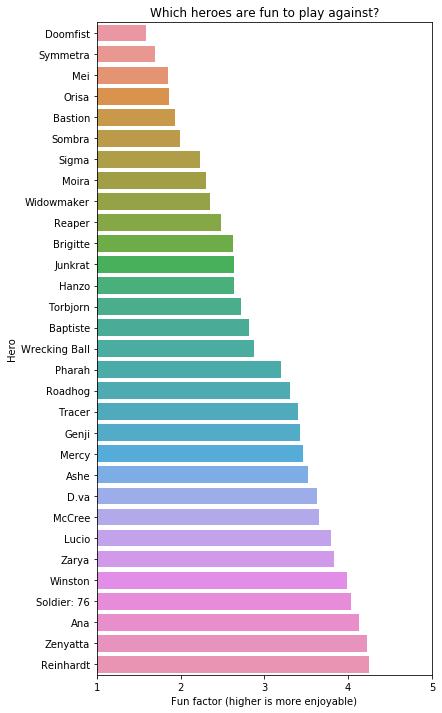

In [7]:
draw_fun_factor_graph(
    hero_fun_factor(joined_df, COLUMN_PLAYING_VS), 
    "Which heroes are fun to play against?")

## Q: Which heroes are more fun to play as than to play against?
Rationale: Optimising for the fun of one player at the expense of 6 others might tell us something about why certain heroes are strongly disliked by the playerbase. 

E.g. `Doomfist` might be satisfying to play, as it's rewarding to pull off combos that have high mechanical skill requirements. However, the players on the receiving end may feel helpless and demoralised.

On the other hand, players may enjoy fragging out on `Zen`, but this is tempered by `Zen`'s sphere-like hitbox & squishy nature.

In [8]:
def hero_fun_as_vs(df):
    """
    Q: For each hero, how fun are they to play _as_ instead of _against_?
    (e.g. a hero might be very fun to play as, but very un-fun to play against)
    """
    playing_as_df = (df.query('Response_type == "Playing_as"')
     .groupby('Hero')
     .mean())
    
    playing_vs_df = (df.query('Response_type == "Playing_vs"')
     .groupby('Hero')
     .mean())   
   
    fun_difference_df = (playing_as_df.join(
        playing_vs_df,    
        lsuffix='_fun_as', 
        rsuffix='_fun_vs'))      
    
    fun_difference_df["Value_fun_difference"] = (
        fun_difference_df["Value_fun_as"] - 
        fun_difference_df["Value_fun_vs"])

    fun_difference_df.sort_values(by="Value_fun_difference", inplace=True)
                
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    
    ax = sb.barplot(x="Value_fun_difference", y=fun_difference_df.index, data=fun_difference_df)    
    ax.set(xlabel="Playing as/vs fun difference", ylabel="Hero")
        
    plt.axvline(0.0, 0.0, 1.0).set_linestyle('dashed')    

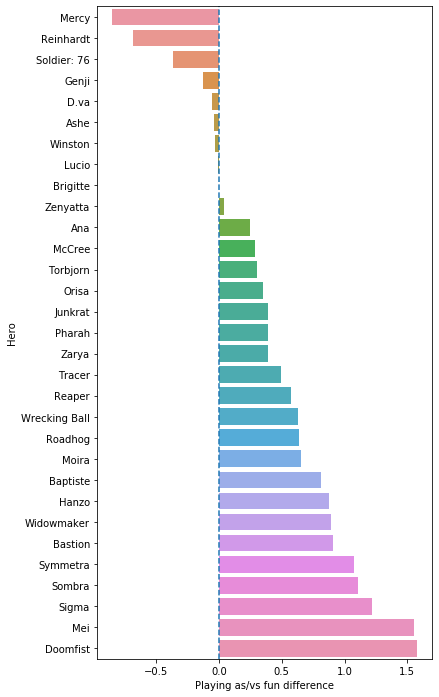

In [9]:
hero_fun_as_vs(joined_df)

## Q: Where do heroes fall on the balance scale? 
Rationale: Gives us a feel for heroes that are considered weak/balanced/over-tuned (aka OP)

In [10]:
def hero_balance(df):
    return (joined_df.query('Response_type == "Balance"')
            .groupby('Hero', as_index=False)
            .mean()
            .sort_values(by='Value'))

In [11]:
def draw_hero_balance_graph(df):
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    ax = sb.barplot(x="Value", y="Hero", data=df)
    set_graph_format_x_axis(ax)
    
    # plot ideal balance line
    balance_line_x = CHART_BAR_FIGSIZE[0] * 0.5
    plt.axvline(balance_line_x, 0.0, 1.0).set_linestyle('dashed')
    
    ax.set_title("Which heroes are perceived to be balanced?")
    ax.set(xlabel="Balance rating -- 3 is considered to be well-balanced")

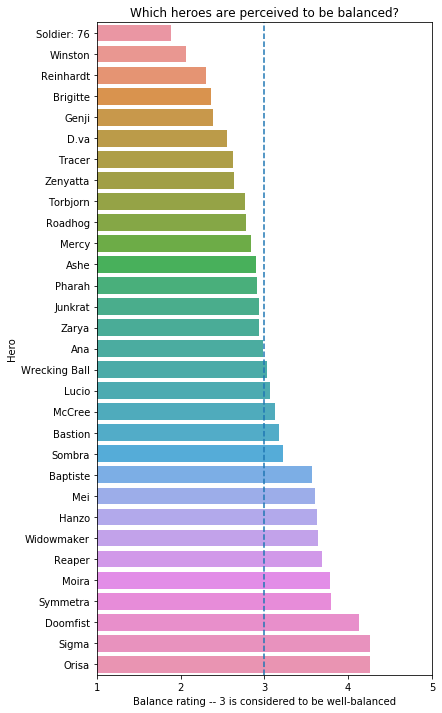

In [12]:
draw_hero_balance_graph(hero_balance(joined_df))

### Let's break down balance by hero & see the range of votes
Rationale: More of a curiosity, but are heroes viewed largely uniformly (bell curve distribution) or are some heroes more divisive, with a more equal distribution of votes for weak/balanced/OP?

In [17]:
@interact
def hero_balance_histograms(column=list(sorted(hero_names_df['Hero_name']))):
    hero_playing_vs_df = (joined_df.query('Response_type == "Playing_vs"')
                          .groupby('Hero'))['Value']

    # todo: figure out how to make the axis labels marry up with the result buckets a bit better.
    f, ax = plt.subplots(figsize=CHART_HIST_FIGSIZE)
    sb.set_style("ticks")
    dp = sb.distplot(hero_playing_vs_df.get_group(column), bins=5, kde=False)
    dp.set(xlabel=f'Playing vs {column}', ylabel='Counts')    
    plt.show()        

interactive(children=(Dropdown(description='column', options=('Ana', 'Ashe', 'Baptiste', 'Bastion', 'Brigitte'…

## Q: Which heroes are fun to play against relative to their perceived balance?
Rationale: I'd expect to see an inversely proportional relationship between hero strength and fun (i.e. the more OP a hero is, the less fun it is to play against them). 

Are there any weak heroes that significantly buck this trend? If so, it suggests the hero design may have inherent problems.

In [18]:
def hero_fun_vs_balance(df):
    """
    Q: which heroes are unpopular relative to their perceived balance level? 
    (i.e. people dislike playing against them even if they're not considered OP)
    """
    playing_vs_df = (df.query('Response_type == "Playing_vs"')
     .groupby('Hero')
     .mean())
    
    balance_df = (df.query('Response_type == "Balance"')
     .groupby('Hero')
     .mean())
    
    # our fun and balance ranges go from [1, 5], so let's move them into the range
    # 0 to 4, then transform them into the range [-1, +1]. E.g. a 1 => -1, 5 => 1
    # this will make it easy to see if they 'cancel out' or not
    playing_vs_df = (playing_vs_df - 3.0) / 2.0
    balance_df = (balance_df - 3.0) / 2.0
    
    fun_balance_df = (playing_vs_df.join(
        balance_df,    
        lsuffix='_fun', 
        rsuffix='_balance')
      .query('Value_balance.notnull()')) # filter out the invalid joined data; should do this first though
    
    # this is a little arbitrary, but gives us a decent idea of 'fun/unfun' vs balance.    
    # we have a fun rating range [-1, 1] and a strength rating range [-1, 1]. 
    # 
    # we'd expect to see something of an inverse relationship between fun and balance,
    # so we're going to add them together and plot the whole lot. Adding the two values
    # should roughly cancel out, and anything that significantly departs from 0 should 
    # give us a feel for outliers in a fun/power relationship.
    # 
    # Examples:
    #
    # 1. hero that is viewed as well-balanced and also OK to play against:
    #   fun: 0.1, strength: -0.05 (i.e. these values are both close to 0)
    #   result: 0.1 + (-0.05) = 0.05
    #   interpretation: fun and balance are in check
    #
    # 2. hero that is un-fun and also also weak:
    #   fun: -0.5, strength: -0.3 (i.e. these values are both negative)
    #   result: -0.5 + (-0.3) = -0.8
    #   interpretation: the hero design has inherently un-fun elements even though weak.
    #
    # 3. hero that is fun and also slightly OP
    #   fun: 0.7, strength: 0.3
    #   result: 0.7 + 0.3 = 1.0
    #   interpretation: the hero design is inherently so much fun that we forgive the OPness
    fun_balance_df["Value_relative_balance"] = (
        fun_balance_df["Value_balance"] + 
        fun_balance_df["Value_fun"])

    fun_balance_df.sort_values(by="Value_relative_balance", inplace=True)
                
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    
    ax = sb.barplot(x="Value_relative_balance", y=fun_balance_df.index, data=fun_balance_df)    
    ax.set(xlabel="Playing vs. Hero: fun relative to balance", ylabel="Playing against hero")
    
    # plot balance vs. fun baseline. Any hero to the <--- left of this line is considered
    # un-fun relative to their balance level. 
    balance_line_x = 0.0
    plt.axvline(balance_line_x, 0.0, 1.0).set_linestyle('dashed')


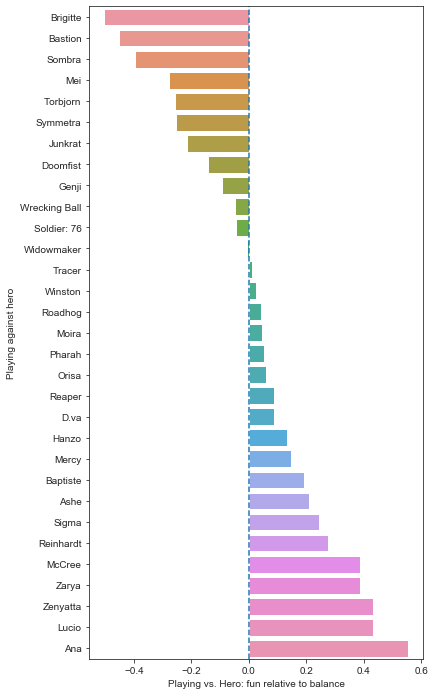

In [19]:
hero_fun_vs_balance(joined_df)

## Q: When maining a specific hero, which heroes are fun/un-fun to play against?
Rationale: Do the hero fun/un-fun rankings change significantly by which hero the respondents main, or are some heroes just universally unpopular to play against?

E.g. my hunch is Zen mains hate Doomfist the most, while Wrecking Ball mains hate Sombra or possibly Mei.

In [16]:
def hero_fun_vs_balance_by_main(df, hero_names):    
    @interact
    def hero_fun_vs_balance_by_main_interact(column=hero_names):        
        hero_name = column
        hero_playing_as_df = (df.query(
            f'Hero_favourite == "{hero_name}" & Response_type == "Playing_vs"'))
                
        response_count_for_main = int(len(hero_playing_as_df) / len(hero_names))
        
        if response_count_for_main < 1:            
            print(f"There were {response_count_for_main} responses from {hero_name} mains. Nothing to display.")
            return        

        # for hero x, we have results for playing against all heroes. 
        # spin through every result in this set and query for the top 3 most-hated
        least_fun_group = (hero_playing_as_df
                           .query(f'Response_type == "Playing_vs"')
                           .groupby("Hero", as_index=False))

        least_fun_mean = (least_fun_group.mean()
                          .sort_values(by='Value'))
        
        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
        ax = sb.barplot(x="Value", y="Hero", data=least_fun_mean)
        #set_graph_format_x_axis(ax)
        ax.set_title(f"Respondents' main: {hero_name}. (N: {response_count_for_main})")
        ax.set(xlabel="Fun factor (higher is more enjoyable)", ylabel="Playing against hero")
        set_graph_format_x_axis(ax)
        
hero_fun_vs_balance_by_main(joined_df, list(sorted(hero_names_df['Hero_name'])))

interactive(children=(Dropdown(description='column', options=('Ana', 'Ashe', 'Baptiste', 'Bastion', 'Brigitte'…